## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet169 Model](#model)  ##
## [5. Training and Fine Tuning](#train) ##
## [6. Visualizing Results](#vis) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [29]:
train_dir = "/content/drive/MyDrive/CNN/train"
test_dir = "/content/drive/MyDrive/CNN/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Angry', 'Happy','Sad']
CLASS_LABELS_EMOJIS = ["👿","😊", "😔" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [30]:
preprocess_fun = tf.keras.applications.regnet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 1823 images belonging to 3 classes.
Found 455 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


## Images with different emotions

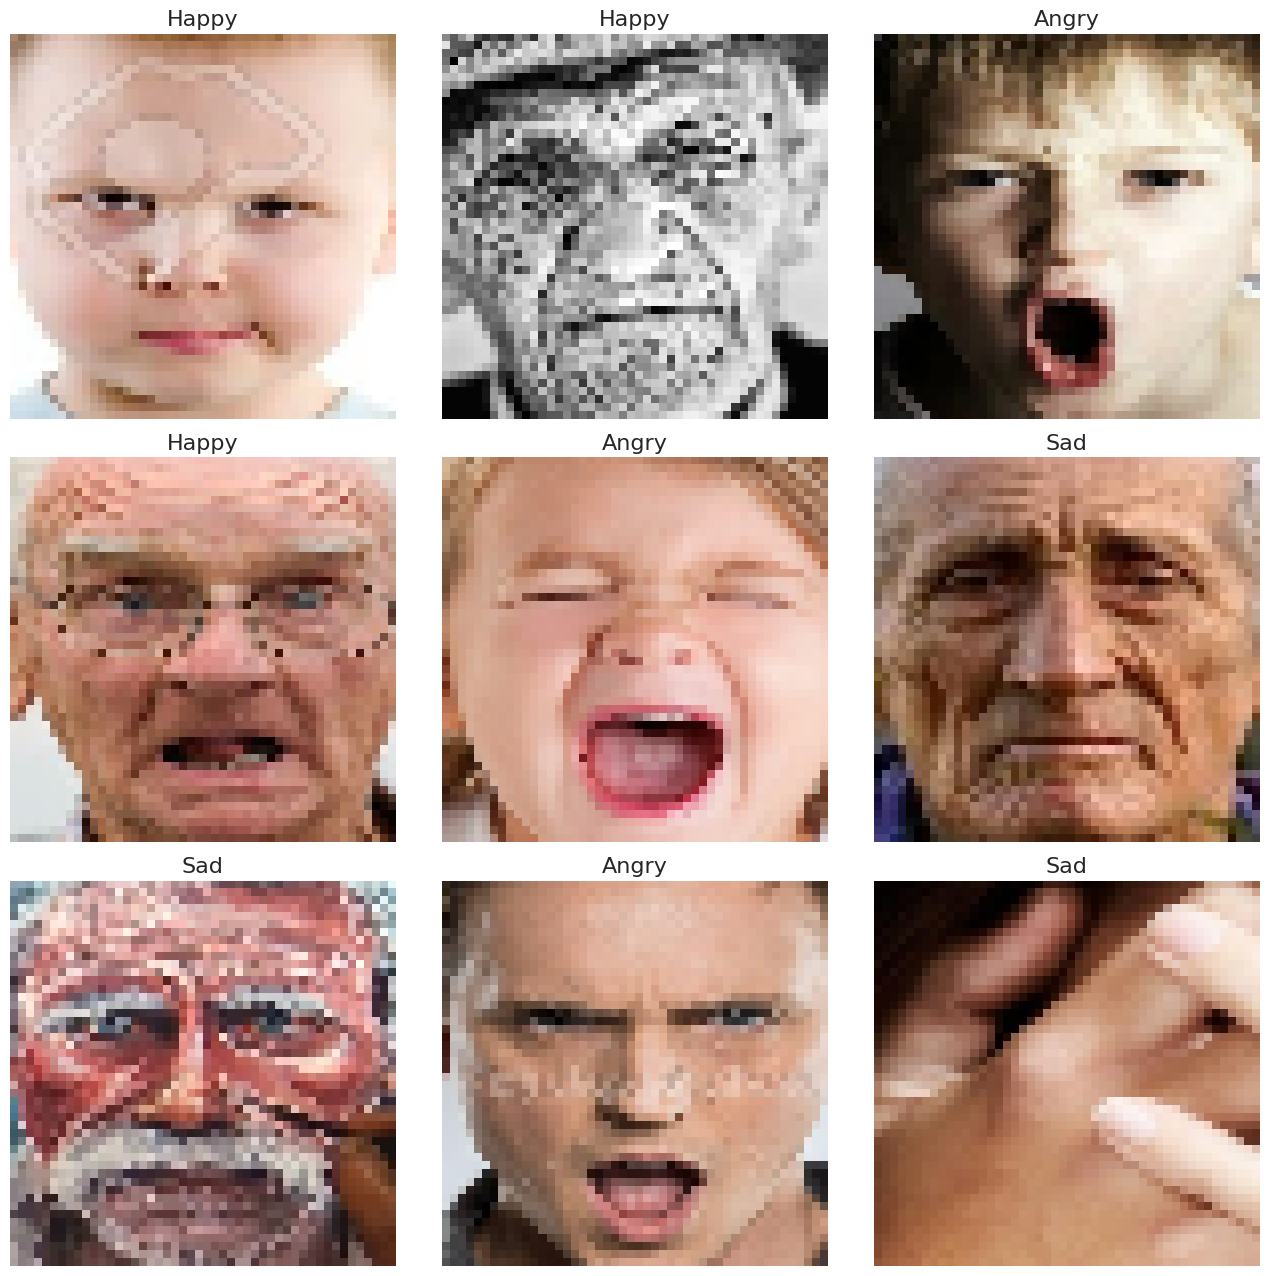

In [31]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [32]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> Regnet Transfer Learning  </center>

In [33]:
from tensorflow.keras.applications import regnet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.RegNetX004(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [34]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# def feature_extractor(inputs):
#     # Use ResNet50 as the feature extractor
#     resnet_feature_extractor = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#                                         include_top=False,
#                                         weights='imagenet')(inputs)

#     return resnet_feature_extractor

# def classifier(inputs):
#     x = GlobalAveragePooling2D()(inputs)
#     x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = Dropout(0.3)(x)
#     x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     x = Dense(3, activation="softmax", name="classification")(x)

#     return x

# def final_model(inputs):
#     resnet_feature_extractor = feature_extractor(inputs)
#     classification_output = classifier(resnet_feature_extractor)

#     return classification_output

# def define_compile_model():
#     inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#     classification_output = final_model(inputs)
#     model = tf.keras.Model(inputs=inputs, outputs=classification_output)

#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

## Summary of model

In [35]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 regnetx004 (Functional)     (None, 2, 2, 384)         4809184   
                                                                 
 global_average_pooling2d_1  (None, 384)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               98560     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                           

<a id="train"></a>
# <center> Training and Fine-Tuning </center>

## Training model with freezed layers of Regnet


In [36]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
29/29 [==============================] - 45s 680ms/step - loss: 14.5138 - accuracy: 0.3390 - val_loss: 13.5285 - val_accuracy: 0.4286
Epoch 2/30
29/29 [==============================] - 7s 235ms/step - loss: 12.8598 - accuracy: 0.4021 - val_loss: 12.1489 - val_accuracy: 0.4330
Epoch 3/30
29/29 [==============================] - 7s 228ms/step - loss: 11.5506 - accuracy: 0.4202 - val_loss: 10.8964 - val_accuracy: 0.5275
Epoch 4/30
29/29 [==============================] - 8s 289ms/step - loss: 10.3988 - accuracy: 0.4087 - val_loss: 9.8107 - val_accuracy: 0.4879
Epoch 5/30
29/29 [==============================] - 7s 227ms/step - loss: 9.3608 - accuracy: 0.4476 - val_loss: 8.8272 - val_accuracy: 0.5187
Epoch 6/30
29/29 [==============================] - 7s 254ms/step - loss: 8.4315 - accuracy: 0.4509 - val_loss: 7.9933 - val_accuracy: 0.4747
Epoch 7/30
29/29 [==============================] - 8s 281ms/step - loss: 7.6300 - accuracy: 0.4580 - val_loss: 7.2029 - val_accuracy: 0.525

## Fine Tuning

In [37]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
29/29 [==============================] - 27s 316ms/step - loss: 1.2327 - accuracy: 0.6610 - val_loss: 1.3580 - val_accuracy: 0.5780
Epoch 2/20
29/29 [==============================] - 8s 272ms/step - loss: 1.2238 - accuracy: 0.6802 - val_loss: 1.3476 - val_accuracy: 0.5824
Epoch 3/20
29/29 [==============================] - 7s 245ms/step - loss: 1.2263 - accuracy: 0.6747 - val_loss: 1.3478 - val_accuracy: 0.5846
Epoch 4/20
29/29 [==============================] - 8s 273ms/step - loss: 1.2261 - accuracy: 0.6698 - val_loss: 1.3440 - val_accuracy: 0.5802
Epoch 5/20
29/29 [==============================] - 7s 243ms/step - loss: 1.2230 - accuracy: 0.6791 - val_loss: 1.3433 - val_accuracy: 0.5868
Epoch 6/20
29/29 [==============================] - 8s 291ms/step - loss: 1.2017 - accuracy: 0.6775 - val_loss: 1.3453 - val_accuracy: 0.5802
Epoch 7/20
29/29 [==============================] - 7s 230ms/step - loss: 1.2029 - accuracy: 0.6742 - val_loss: 1.3413 - val_accuracy: 0.5846
Epoch

## Training plots

In [38]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [39]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center>

## Model Evaluation

In [40]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

9/9 [==============================] - 3s 158ms/step


## Confusion Matrix

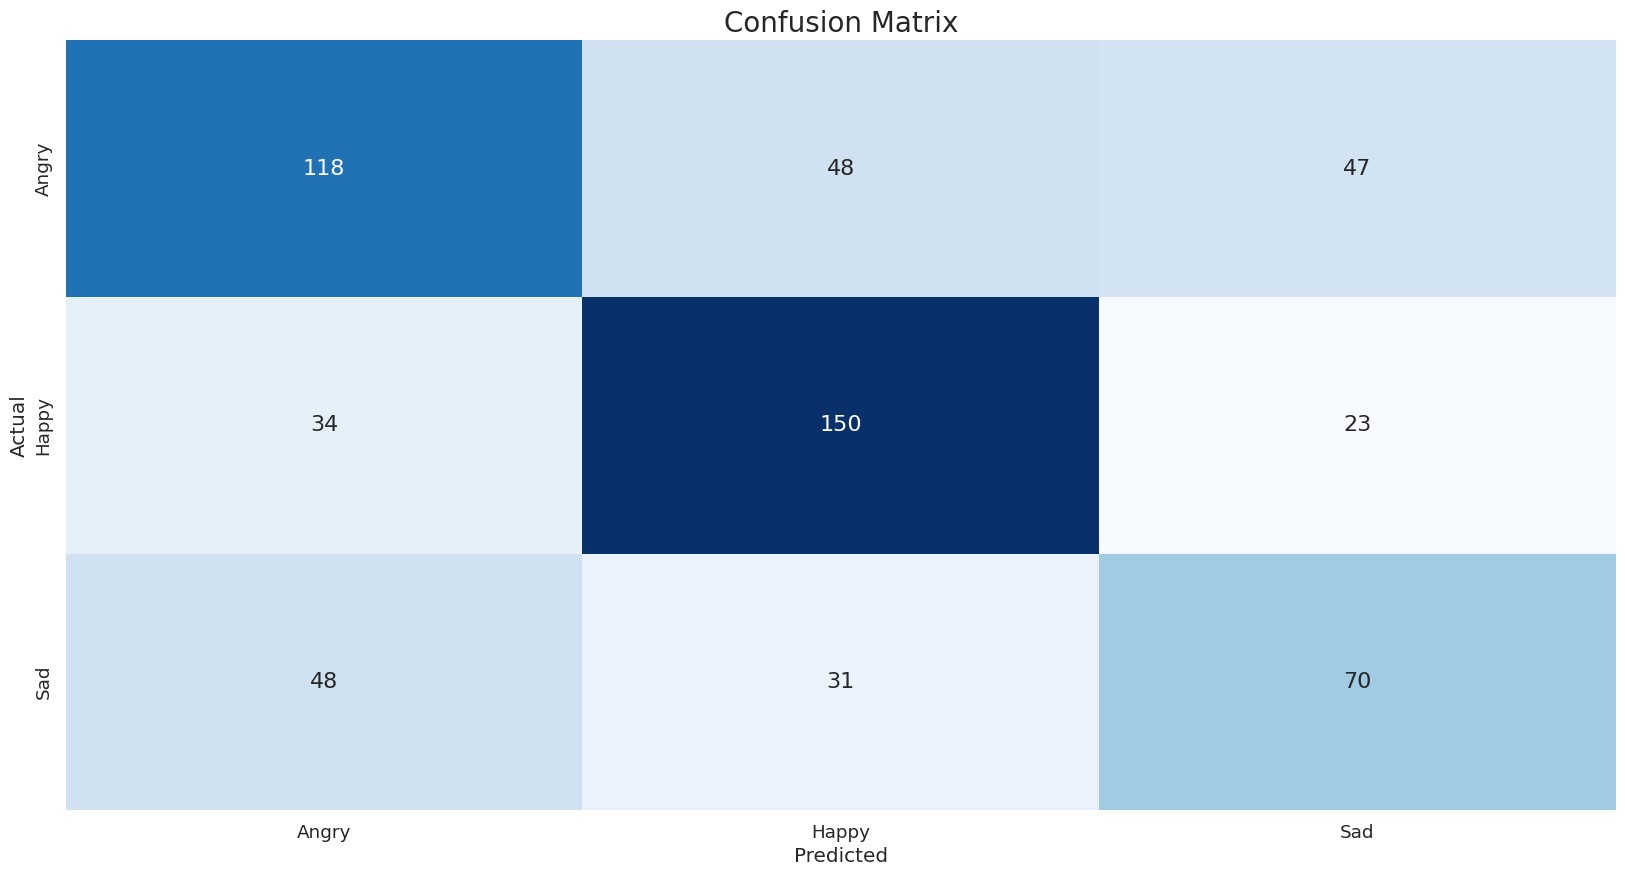

In [41]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report

In [42]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       213
           1       0.66      0.72      0.69       207
           2       0.50      0.47      0.48       149

    accuracy                           0.59       569
   macro avg       0.58      0.58      0.58       569
weighted avg       0.59      0.59      0.59       569



## Multiclass AUC Curve

ROC AUC score: 0.7848011341699588


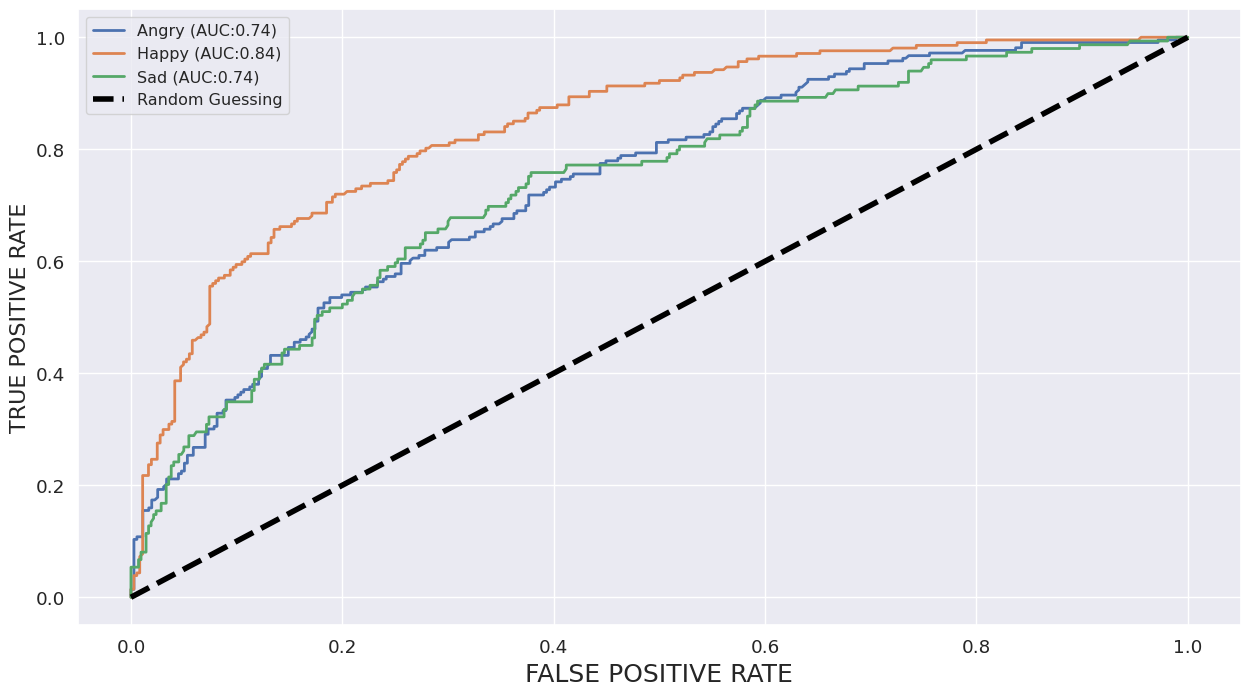

In [43]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [44]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.7739174584926083
